In [13]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from tqdm import tqdm
from scipy.integrate import quad
import pandas as pd
import random
from pyvbmc import VBMC
from V_A_step_jump_fit_utils import PDF_hit_V_A_change, CDF_hit_V_A_change, rho_A_t_fn, cum_A_t_fn
from tqdm import tqdm
import pickle

# data

In [14]:
# read out_LED.csv as dataframe
og_df = pd.read_csv('../out_LED.csv')

# chose non repeat trials - 0 or 2 or missing
df = og_df[ og_df['repeat_trial'].isin([0,2]) | og_df['repeat_trial'].isna() ]

# only session type 7
session_type = 7    
df = df[ df['session_type'].isin([session_type]) ]

# training level 16
training_level = 16
df = df[ df['training_level'].isin([training_level]) ]

# find ABL and ILD
ABL_arr = df['ABL'].unique()
ILD_arr = df['ILD'].unique()


# sort ILD arr in ascending order
ILD_arr = np.sort(ILD_arr)
ABL_arr = np.sort(ABL_arr)

print('ABL:', ABL_arr)
print('ILD:', ILD_arr)

ABL: [20 40 60]
ILD: [-16.  -8.  -4.  -2.  -1.   1.   2.   4.   8.  16.]


In [15]:
df_to_fit = df[ df['LED_trial'] == 1 ]

# remove rows where `intended_fix`, `timed_fix` or `LED_onset_time` is nan
df_to_fit = df_to_fit.dropna(subset=['intended_fix', 'timed_fix', 'LED_onset_time'])

# VBMC

In [16]:
T_trunc = 0.3

In [17]:
# get params from VBMC fit of LED OFF data
with open('LED_OFF_VBMC_LT_RC_VP_DATA_0.pkl', 'rb') as f:
    vp_off = pickle.load(f)

vp_off_samples = vp_off.sample(int(1e6))[0]
V_A_off = np.mean(vp_off_samples[:, 0])
theta_A_off = np.mean(vp_off_samples[:, 1])
t_A_aff_off = np.mean(vp_off_samples[:, 2])

print(f'V_A_off: {V_A_off}, theta_A_off: {theta_A_off}, t_A_aff_off: {t_A_aff_off}')

V_A_off: 1.6138041014888007, theta_A_off: 2.5740013587592454, t_A_aff_off: -0.1992036272851749


In [18]:
base_V_A = V_A_off
theta_A = theta_A_off
t_A_aff = t_A_aff_off
print(f'base_V_A: {base_V_A}, theta_A: {theta_A}, t_A_aff: {t_A_aff}')

base_V_A: 1.6138041014888007, theta_A: 2.5740013587592454, t_A_aff: -0.1992036272851749


In [19]:
def compute_loglike(row, new_V_A):
    rt = row['timed_fix']
    t_stim = row['intended_fix']
    t_led = row['intended_fix'] - row['LED_onset_time']

    
    if rt < T_trunc:
        likelihood = 0
    else:
        if t_led == 0: # only new V_A will be used
            pdf_trunc_factor = 1 - cum_A_t_fn(T_trunc - t_A_aff, new_V_A, theta_A)
            if rt < t_stim:
                likelihood =  rho_A_t_fn(rt - t_A_aff, new_V_A, theta_A) / pdf_trunc_factor
            elif rt > t_stim:
                if t_stim < T_trunc:
                    likelihood = 1
                else:
                    likelihood = ( 1 - cum_A_t_fn(t_stim - t_A_aff, new_V_A, theta_A) ) / pdf_trunc_factor
        else: # V_A change in middle
            trunc_factor = 1 - CDF_hit_V_A_change(T_trunc - t_A_aff, base_V_A, new_V_A, theta_A, t_led)
            if rt < t_stim:
                likelihood = PDF_hit_V_A_change(rt-t_A_aff, base_V_A, new_V_A, theta_A, t_led) / trunc_factor
            elif rt > t_stim:
                if t_stim < T_trunc: # if stim is before truncation, the abort prob = 0
                    likelihood = 1
                else:
                    likelihood = ( 1 - CDF_hit_V_A_change(t_stim - t_A_aff, base_V_A, new_V_A, theta_A, t_led) ) / trunc_factor

    if likelihood <= 0:
        likelihood = 1e-50

    
    return np.log(likelihood)    



def psiam_tied_loglike_fn(params):
    new_V_A = params[0]

    all_loglike = Parallel(n_jobs=30)(delayed(compute_loglike)(row, new_V_A)\
                                      for _, row in df_to_fit.iterrows()) 
                                   

    loglike = np.sum(all_loglike)
    return loglike

# bounds

In [20]:
new_V_A_bounds = [0.1, 5]

new_V_A_plausible_bounds = [0.5, 3]

# prior

In [21]:
def trapezoidal_logpdf(x, a, b, c, d):
    if x < a or x > d:
        return -np.inf  # Logarithm of zero
    area = ((b - a) + (d - c)) / 2 + (c - b)
    h_max = 1.0 / area  # Height of the trapezoid to normalize the area to 1
    
    if a <= x <= b:
        pdf_value = ((x - a) / (b - a)) * h_max
    elif b < x < c:
        pdf_value = h_max
    elif c <= x <= d:
        pdf_value = ((d - x) / (d - c)) * h_max
    else:
        pdf_value = 0.0  # This case is redundant due to the initial check

    if pdf_value <= 0.0:
        return -np.inf
    else:
        return np.log(pdf_value)
    

def vbmc_prior_abort_fn(params):
    new_V_A = params[0]

    new_V_A_logpdf = trapezoidal_logpdf(new_V_A, new_V_A_bounds[0], new_V_A_plausible_bounds[0], new_V_A_plausible_bounds[1], new_V_A_bounds[1])
    return new_V_A_logpdf

# joint

In [22]:
def vbmc_joint(params):
    return vbmc_prior_abort_fn(params) + psiam_tied_loglike_fn(params)

# run vbmc

In [23]:
lb = [new_V_A_bounds[0]]
ub = [new_V_A_bounds[1]]

plb = [new_V_A_plausible_bounds[0]]
pub = [new_V_A_plausible_bounds[1]]

np.random.seed(42)
new_V_A_0 = np.random.uniform(new_V_A_plausible_bounds[0], new_V_A_plausible_bounds[1])

x_0 = np.array([new_V_A_0])

In [24]:
vbmc = VBMC(vbmc_joint, x_0, lb, ub, plb, pub, options={'display': 'off'})
vp, results = vbmc.optimize()

Reshaping x0 to row vector.
Reshaping lower bounds to (1, 1).
Reshaping upper bounds to (1, 1).
Reshaping plausible lower bounds to (1, 1).
Reshaping plausible upper bounds to (1, 1).
Casting upper bounds to floating point.
Casting plausible upper bounds to floating point.
Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -154274.163 +/-0.001.


In [25]:
# save vbmc
vp.save('ONLY_1D_V_A_step_jump_LED_on_vbmc.pkl', overwrite=True)

In [ ]:
import pickle
with open('ONLY_1D_V_A_step_jump_LED_on_vbmc.pkl', 'rb') as f:
    vp = pickle.load(f)

# corner plot

In [27]:
combined_samples.shape

(1, 1000000)

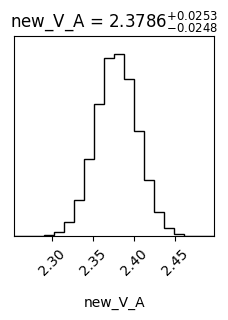

In [28]:
import corner
vp_samples = vp.sample(int(1e6))[0]
new_V_A_samp = vp_samples[:,0]

combined_samples = np.transpose(np.vstack((new_V_A_samp)))
param_labels = ['new_V_A']
corner.corner (new_V_A_samp, labels=param_labels, show_titles=True, title_fmt=".4f");


# fit and see - all

In [29]:
base_V_A_mean = base_V_A
new_V_A_mean = np.mean(new_V_A_samp)
theta_A_mean = theta_A
t_A_aff_mean = t_A_aff

In [30]:
# data
df_to_fit = df_to_fit.dropna(subset=['timed_fix', 'intended_fix', 'LED_onset_time'])
data_abort_rt = df_to_fit[ (df_to_fit['timed_fix'] < df_to_fit['intended_fix']) & \
                            (df_to_fit['timed_fix'] > T_trunc) ]['timed_fix'].values

bin_width = 0.03
bins = np.arange(0, np.max(data_abort_rt), bin_width)
t_pts = bins[:-1] + bin_width / 2

bw_theory = 0.01
bins_theory = np.arange(0, np.max(data_abort_rt), bw_theory)
t_pts_theory = bins_theory[:-1] + bw_theory / 2

frac_of_aborts_data = len(data_abort_rt) / len(df_to_fit)
print(f'frac of aborts = {frac_of_aborts_data}')

frac of aborts = 0.1637131605691057


In [31]:
def calc_trunc_pdf(t, base_V_A, new_V_A, theta_A, t_A_aff, t_led, trunc_factor, t_stim):   
    # pdf
    if t_led == 0:
        if t <= T_trunc or t >= t_stim:
            pdf = 0
        else:
            trunc_factor = 1 - cum_A_t_fn(T_trunc - t_A_aff, new_V_A, theta_A)
            pdf = rho_A_t_fn(t - t_A_aff, new_V_A, theta_A) / trunc_factor
    else:
        if t <= T_trunc or t >= t_stim:
            pdf = 0
        else:
            pdf = PDF_hit_V_A_change(t - t_A_aff, base_V_A, new_V_A, theta_A, t_led) / trunc_factor
    
    if t > t_stim:
        pdf = 0

    return pdf

def calc_trunc_cdf(base_V_A, new_V_A, theta_A, t_A_aff, t_led, t_stim, trunc_factor):
    # cdf
    if t_stim <= T_trunc:
        return 0
    if t_led == 0:
        trunc_factor = 1 - cum_A_t_fn(T_trunc - t_A_aff, new_V_A, theta_A)
        cdf = cum_A_t_fn(t_stim - t_A_aff, new_V_A, theta_A) / trunc_factor
    else:
        cdf = (CDF_hit_V_A_change(t_stim - t_A_aff, base_V_A, new_V_A, theta_A, t_led)) / trunc_factor
    return cdf


In [32]:
sampled_pairs = list(zip(df_to_fit['intended_fix'], df_to_fit['intended_fix'] - df_to_fit['LED_onset_time']))
N_theory = len(sampled_pairs)
print(f'N_theory = {N_theory}')

N_theory = 31488


In [33]:
from joblib import Parallel, delayed
import numpy as np
from tqdm import tqdm
from scipy.integrate import trapezoid

pdf_ensemble = np.zeros((N_theory, len(t_pts_theory)))
cdf_ensemble = np.zeros((N_theory, ))
all_areas_pdf_ensemble = np.zeros((N_theory, ))

def process_pair(i, t_stim, t_led):
    if t_stim <= t_led:
        print('Issue at index:', i)
        return i, None, None, None
    
    trunc_factor = 1 - CDF_hit_V_A_change(T_trunc - t_A_aff_mean, base_V_A_mean, new_V_A_mean, theta_A_mean, t_led)
    pdf_row = np.array([calc_trunc_pdf(t, base_V_A_mean, new_V_A_mean, theta_A_mean, t_A_aff_mean, t_led, trunc_factor, t_stim) 
                        for t in t_pts_theory])
    area_val = trapezoid(pdf_row, t_pts_theory)
    cdf_val = calc_trunc_cdf(base_V_A_mean, new_V_A_mean, theta_A_mean, t_A_aff_mean, t_led, t_stim, trunc_factor)
    return i, pdf_row, cdf_val, area_val

# Run parallel computations using 30 cores
results = Parallel(n_jobs=30)(delayed(process_pair)(i, t_stim, t_led) for i, (t_stim, t_led) in tqdm(enumerate(sampled_pairs)))

# Assign results back into the arrays in order
for i, pdf_row, cdf_val, area_val in results:
    if pdf_row is not None:  # only assign if we have a valid result
        pdf_ensemble[i,:] = pdf_row
        cdf_ensemble[i] = cdf_val
        all_areas_pdf_ensemble[i] = area_val


31488it [00:57, 549.77it/s]


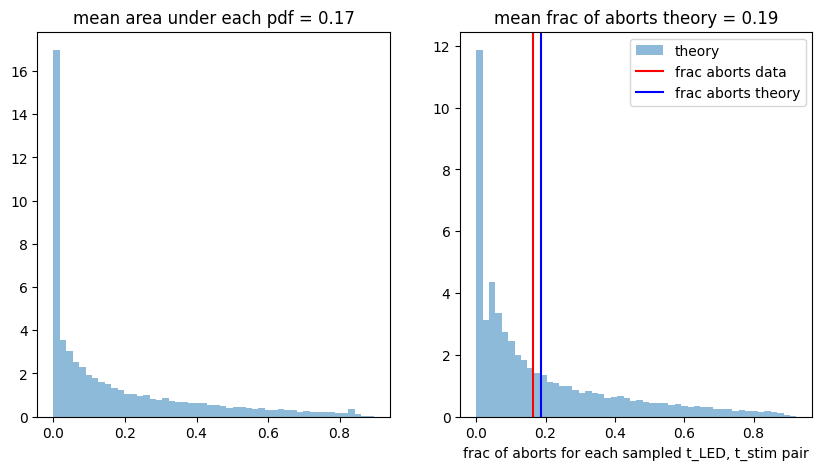

In [34]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.hist(all_areas_pdf_ensemble, bins=50, density=True, alpha=0.5, label='theory')
plt.title(f'mean area under each pdf = {np.mean(all_areas_pdf_ensemble):.2f}');

plt.subplot(1,2,2)
plt.hist(cdf_ensemble, bins=50, density=True, alpha=0.5, label='theory')
plt.title(f'mean frac of aborts theory = {np.mean(cdf_ensemble):.2f}');
plt.axvline(frac_of_aborts_data, color='r', label='frac aborts data')
plt.axvline(np.mean(cdf_ensemble), color='b', label='frac aborts theory')
plt.xlabel('frac of aborts for each sampled t_LED, t_stim pair')

plt.legend();

In [35]:
# sanity checks
cdf_ensemble_mean = np.mean(cdf_ensemble)
pdf_ensemble_mean = np.mean(pdf_ensemble, axis=0)
print(f'pdf ensemble mean shape = {pdf_ensemble_mean.shape}')
print(f'frac aborts theory = {cdf_ensemble_mean}, frac aborts data = {frac_of_aborts_data}')
print(f'area under pdf ensemble mean = {trapezoid(pdf_ensemble_mean, t_pts_theory)}')

pdf ensemble mean shape = (200,)
frac aborts theory = 0.18693384728081888, frac aborts data = 0.1637131605691057
area under pdf ensemble mean = 0.17446686094019442


In [36]:
abort_rt_hist, _ = np.histogram(data_abort_rt, bins=bins, density=True)
abort_rt_hist *= frac_of_aborts_data # to make area frac of aborts


pdf_ensemble_mean_norm = pdf_ensemble_mean* cdf_ensemble_mean # so that area is frac of aborts

area ubnder theory = 0.17446686094019442
area under data = 0.16369727842314438


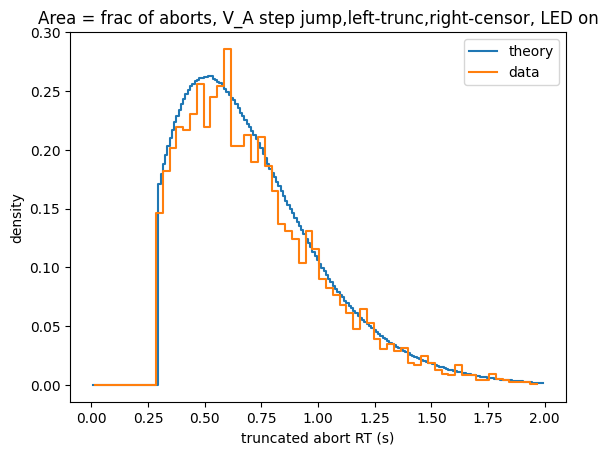

In [37]:
plt.step(t_pts_theory, pdf_ensemble_mean, label='theory')
plt.step(t_pts, abort_rt_hist, label='data')

plt.legend()

plt.xlabel('truncated abort RT (s)')
plt.ylabel('density')
plt.title('Area = frac of aborts, V_A step jump,left-trunc,right-censor, LED on')

print(f'area ubnder theory = {trapezoid(pdf_ensemble_mean, t_pts_theory)}')
print(f'area under data = {trapezoid(abort_rt_hist, t_pts)}')


# align to led onset

In [38]:
df_to_fit_truncated_abort = df_to_fit[ (df_to_fit['timed_fix'] < df_to_fit['intended_fix']) &  (df_to_fit['timed_fix'] > T_trunc) ]
df_to_fit_trunc_abort_aligned_to_led = df_to_fit_truncated_abort['timed_fix'] - \
                                        (df_to_fit_truncated_abort['intended_fix'] - df_to_fit_truncated_abort['LED_onset_time'])

## adding

parallel version

In [39]:
bw = 0.01
bins = np.arange(-3,3,bw)
t_pts = bins[:-1] + bw / 2

from joblib import Parallel, delayed
import numpy as np
from tqdm import tqdm

# Assuming the following are already defined:
# bw, bins, t_pts, N_theory, sampled_pairs
# T_trunc, t_A_aff_mean, base_V_A_mean, new_V_A_mean, theta_A_mean
# CDF_hit_V_A_change, calc_trunc_pdf, calc_trunc_cdf, trapezoid

pdf_ensemble_aligned_to_led = np.full((N_theory, len(t_pts)), np.nan)
cdf_ensemble_aligned_to_led = np.full((N_theory,), np.nan)
all_areas_aligned_to_led = np.zeros((N_theory, ))

def process_pair(i, t_stim, t_led):
    # If invalid pair, handle it
    if t_stim <= t_led:
        print('Issue at index:', i)
        # Return empty arrays or None
        return i, None, None, None

    trunc_factor = 1 - CDF_hit_V_A_change(T_trunc - t_A_aff_mean, base_V_A_mean, new_V_A_mean, theta_A_mean, t_led)

    # We'll build a temporary array for pdf values for this iteration
    pdf_row = np.full((len(t_pts),), np.nan)
    for ti, t in enumerate(t_pts):
        t_prime = t + t_led
        if t_prime < 0:
            continue
        pdf_row[ti] = calc_trunc_pdf(t_prime, base_V_A_mean, new_V_A_mean, theta_A_mean, t_A_aff_mean, t_led, trunc_factor, t_stim)
    
    area_val = trapezoid(np.nan_to_num(pdf_row), t_pts)

    cdf_val = calc_trunc_cdf(base_V_A_mean, new_V_A_mean, theta_A_mean, t_A_aff_mean, t_led, t_stim, trunc_factor)
    
    return i, pdf_row, cdf_val, area_val

# Use 30 cores for parallel processing
results = Parallel(n_jobs=30)(
    delayed(process_pair)(i, t_stim, t_led) 
    for i, (t_stim, t_led) in tqdm(enumerate(sampled_pairs), total=N_theory)
)

# Assign results back into the arrays
for i, pdf_row, cdf_val, area_val in results:
    if pdf_row is not None:  # Only assign if results are valid
        pdf_ensemble_aligned_to_led[i, :] = pdf_row
        cdf_ensemble_aligned_to_led[i] = cdf_val
        all_areas_aligned_to_led[i] = area_val


  0%|          | 0/31488 [00:00<?, ?it/s]

100%|██████████| 31488/31488 [00:57<00:00, 547.19it/s]


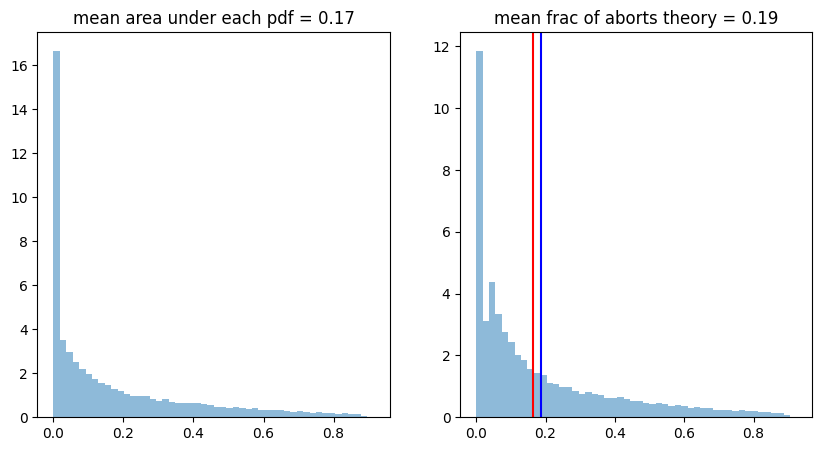

In [40]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.hist(all_areas_aligned_to_led, bins=50, density=True, alpha=0.5, label='theory')
plt.title(f'mean area under each pdf = {np.mean(all_areas_aligned_to_led):.2f}');

plt.subplot(1,2,2)
plt.hist(cdf_ensemble_aligned_to_led, bins=50, density=True, alpha=0.5, label='theory')
plt.title(f'mean frac of aborts theory = {np.mean(cdf_ensemble_aligned_to_led):.2f}');
plt.axvline(frac_of_aborts_data, color='r', label='frac aborts data')
plt.axvline(np.mean(cdf_ensemble_aligned_to_led), color='b', label='frac aborts theory')

## nan -> 0

area under theory = 0.1746007716922556
area under data = 0.1637131605691057


Text(0.5, 1.0, 'Aligned to LED onset ')

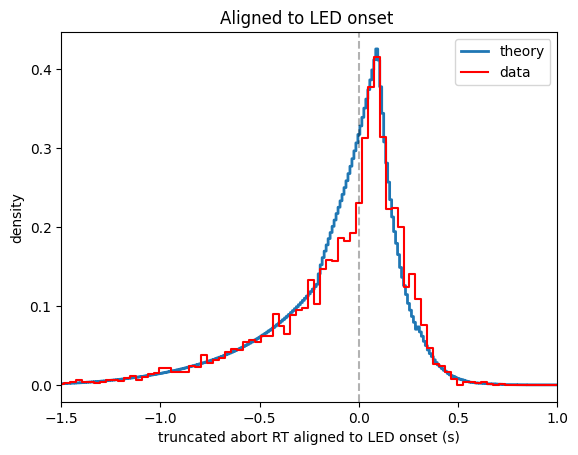

In [41]:
# without nan mean
# pdf_ensemble_aligned_to_led_mean = np.nanmean(pdf_ensemble_aligned_to_led, axis=0)
pdf_ensemble_aligned_to_led_mean_1 = np.mean(np.nan_to_num(pdf_ensemble_aligned_to_led), axis=0)

plt.step(t_pts, pdf_ensemble_aligned_to_led_mean_1, label='theory', lw=2)

bw_2 = 0.03
bins_2 = np.arange(-3,3, bw_2)
t_pts_2 = bins_2[:-1] + bw_2 / 2
aligned_to_led_hist, _ = np.histogram(df_to_fit_trunc_abort_aligned_to_led, bins=bins_2, density=True)
aligned_to_led_hist *= frac_of_aborts_data # to make area frac of aborts
plt.step(t_pts_2, aligned_to_led_hist, label='data', color='r')

plt.legend()
plt.xlabel('truncated abort RT aligned to LED onset (s)')
plt.xlim(-2,2)
# nan replaced with 0 
pdf_ensemble_aligned_to_led_mean_not_nan = np.nan_to_num(pdf_ensemble_aligned_to_led_mean_1)
print(f'area under theory = {trapezoid(pdf_ensemble_aligned_to_led_mean_1, t_pts)}')
print(f'area under data = {trapezoid(aligned_to_led_hist, t_pts_2)}') 
plt.axvline(0, color='k', linestyle='--', label='LED onset', alpha=0.3)
plt.ylabel('density')   
plt.xlim(-1.5,1)
plt.title('Aligned to LED onset ')

# remove t_led = 0

In [17]:
N_theory = 5000
unique_pairs = list(zip(df_to_fit['intended_fix'], df_to_fit['intended_fix'] - df_to_fit['LED_onset_time']))
# from unique_pairs remove rows where second column is zero
unique_pairs = [pair for pair in unique_pairs if pair[1] != 0]

sampled_pairs = random.sample(unique_pairs, min(N_theory, len(unique_pairs)))

pdf_ensemble = np.zeros((N_theory, len(t_pts)))
cdf_ensemble = np.zeros((N_theory, ))
all_areas_pdf_ensemble = np.zeros((N_theory, ))
for i, (t_stim, t_led) in tqdm(enumerate (sampled_pairs), total=N_theory):
    if t_stim <= t_led:
        print('Issue')
        break
    
    trunc_factor = 1 - CDF_hit_V_A_change(T_trunc - t_A_aff_mean, base_V_A_mean, new_V_A_mean, theta_A_mean, t_led)
    pdf_ensemble[i,:] = [calc_trunc_pdf(t, base_V_A_mean, new_V_A_mean, theta_A_mean, t_A_aff_mean, t_led, trunc_factor) for t in t_pts]
    all_areas_pdf_ensemble[i] = np.trapz(pdf_ensemble[i,:], t_pts)
    # if all_areas_pdf_ensemble[i] < 0.8:
    #     print(f'params = {t_stim, t_led}')
    
    cdf_ensemble[i] = calc_trunc_cdf(base_V_A_mean, new_V_A_mean, theta_A_mean, t_A_aff_mean, t_led, t_stim, trunc_factor)
    # if cdf_ensemble[i] > 0.2:
    #     print(f'params = {t_stim, t_led}')

100%|██████████| 5000/5000 [03:00<00:00, 27.75it/s]


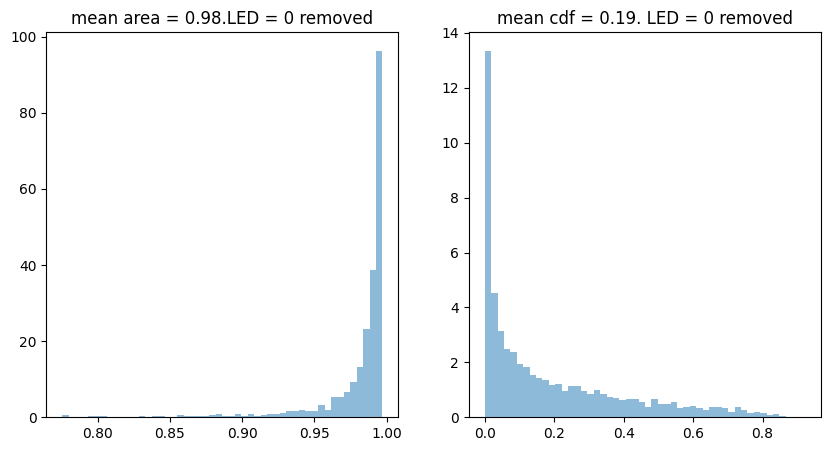

In [18]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.hist(all_areas_pdf_ensemble, bins=50, density=True, alpha=0.5, label='theory')
plt.title(f'mean area = {np.mean(all_areas_pdf_ensemble):.2f}.LED = 0 removed');

plt.subplot(1,2,2)
plt.hist(cdf_ensemble, bins=50, density=True, alpha=0.5, label='theory')
plt.title(f'mean cdf = {np.mean(cdf_ensemble):.2f}. LED = 0 removed');

# led onset distr

In [ ]:
led_onset = df_to_fit['intended_fix'] - df_to_fit['LED_onset_time']
num_led_onset_zero = np.sum(led_onset == 0)
print(f'num led onset zero = {num_led_onset_zero}/{len(df_to_fit)}')
print(f'% led onset zero = {100*num_led_onset_zero / len(df_to_fit)}')